# 🎯 Project Goal


Build a Natural Language Processing (NLP) pipeline to classify IMDb reviews as positive (1) or negative (0) using **TF-IDF + Naive Bayes** classifier. This project demonstrates the end-to-end application of NLP techniques for sentiment analysis in real-world text data.

The dataset consists of the following:

Reviews: Text data containing user opinions about movies.

Sentiments: Labels for each review, where 1 indicates a positive sentiment, and 0 indicates a negative sentiment.

# Setup the Environment

In [1]:
!pip install datasets
!pip install nltk

In [2]:
# Install necessary libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load and Preview the Data

In [3]:
# Load and Prepare the Dataset
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the IMDb dataset from the mounted Drive
file_path = '/content/drive/MyDrive/Final_Mock_Interview_Jyoti_Tidke/IMDb_Reviews.csv'
df = pd.read_csv(file_path)

# Keep only the 'review' and 'sentiment' columns and drop missing values
df = df[['review', 'sentiment']].dropna()

Mounted at /content/drive


In [4]:
# Reduce memory load by limiting to N reviews
N = 50000
df = df.sample(frac=1, random_state=42).reset_index(drop=True).head(N)

print("Data shape after limiting:", df.shape)

Data shape after limiting: (50000, 2)


In [5]:
print('Shape of Dataframe:',df.shape)
pd.set_option('display.max_colwidth', None)
df.head(2)

Shape of Dataframe: (50000, 2)


,review,sentiment
0,"I wanted to love this film so badly...I really did. But it was a horrible disappointment.<br /><br />I read Jennifer Egan's novel in 1996 and was enthralled by the story. In fact it remains one of my favorite books of all time. Mind you, the book had much more depth than this movie, in plot and emotional resonance. It MADE you care about the characters. It painted a complete picture of Phoebe, unlike the utterly poor characterization of the young girl in the film.<br /><br />Though beautiful and showing *some* promise in her burgeoning career, Jordana Brewster was as flat and hollow in this performance as was the script. And Christopher Eccleston (Wolf) was just an awful choice for the role of Wolf, both physically and logistically. What an awkward looking couple. Wolf should have been more of a dark brooding character, and more physically alluring, like he was in the book. What's more, the chemistry between the two actors was painfully forced.<br /><br />Cameron Diaz, however, deserves utmost praise for her performance. She took an impossibly mediocre script and gave her character life, a real spirit. She is simply gorgeous and her careful mannerisms make her very believable as a hippie. It's too bad her talent was squandered on this forgettable film.<br /><br />In the book-to-movie category, this is a dreadful translation, almost as bad as Message in a Bottle with Kevin Costner. But don't get me started on that one...<br /><br />I am not usually so harsh in my critiques but I was so disappointed here, because I really cared about the story and wanted to see it told right. It did not deliver...<br /><br />",0
1,"OK if you are looking for a fun lesbian romp. This is NOT the movie If you are looking for a fun movie with hot sociopathic characters (in the vane of 'cruel intentions' or 'wild things') This is NOT the movie if you are looking for a classic vampire lesbian seductress's movie. This is NOT the movie.<br /><br />However if you are looking to wast an hour of your life, this is your movie. It is badly written, badly directed,badly scored, badly filmed.It had bad special effects...i mean really bad special effects. I think that you can actually generate the same special effects in imovie lol.<br /><br />IT REALLY IS A PRETTY BAD MOVIE.<br /><br />The actors were classic starlet beauties however look more like porn stars. it is shot like a soft core porn however you never get the money shot and the actors all look bored out of their brains. the 'girl on girl' scenes, which suck btw, were so LAME that there hardly worth mentioning. go watch the 'almost sex scenes' on youtube cos that's the only reason you would want to watch this movie and even there not worth it.<br /><br />A WAST OF MONEY AND TIME!!! don't even pick it up, go watch 'Cruel intentions 2' instead - same movie without the bad special effects, bad storyline,bad writing,bad dialog and bad acting. actually i might go watch it now just to purge my mind",0


In [6]:
# Check for missing values
missing_data = df.isnull().sum()
print("Missing Data:\n", missing_data)

Missing Data:
 review       0
sentiment    0
dtype: int64


In [7]:
# Use duplicated() to find duplicate reviews and keep first occurrence
df['review'].duplicated(keep='first')

# Drop duplicate reviews, keeping only the first occurrence
df.drop_duplicates(subset=['review'], keep='first', inplace=True)

# Verify if there are any duplicates present
if df['review'].duplicated().any():
    print("There are duplicate reviews in the dataframe.")
else:
    print("There are no duplicate reviews in the dataframe.")

There are no duplicate reviews in the dataframe.


# Distribution of Sentiments

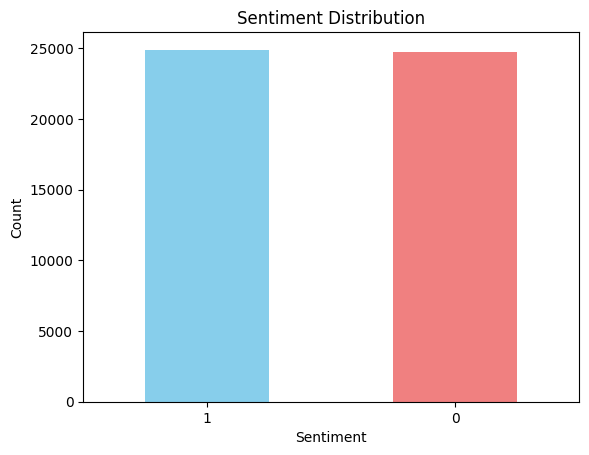

In [8]:
# Plot the distribution of sentiments (positive/negative reviews)
df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

A balanced dataset is preferred for training. If the dataset is imbalanced (more positive or negative reviews), we may need to consider techniques such as resampling or using weighted loss functions.

We analyze the length of reviews to understand their variability. Longer reviews may contain more context, but they also introduce noise. We can decide whether to truncate or pad the reviews based on their lengths.

# Review Length Analysis

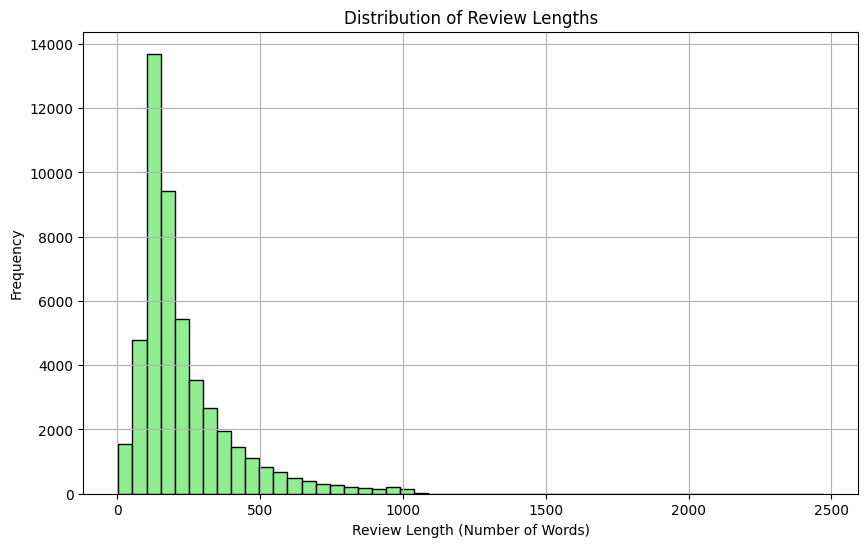

In [9]:
# Add a column for the length of each review
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(10,6))
df['review_length'].hist(bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

Keep all reviews as-is, no truncation needed.

TF-IDF handles variable-length inputs naturally.

Long reviews just get sparser vectors — not a problem.

# Text Cleaning

We clean the text by converting to lowercase, removing numbers, and stripping punctuation. Text cleaning is essential to remove unwanted characters and ensure that the text data is in a uniform, usable format for analysis.

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

df['clean_review'] = df['review'].apply(clean_text)


# Tokenization + Stopword Removal + Word Frequency

We tokenize the text into words and remove common stop words that do not contribute to the sentiment analysis. Tokenization splits the text into words, and removing stopwords eliminates common words like "the", "and", which do not provide useful information for sentiment analysis.

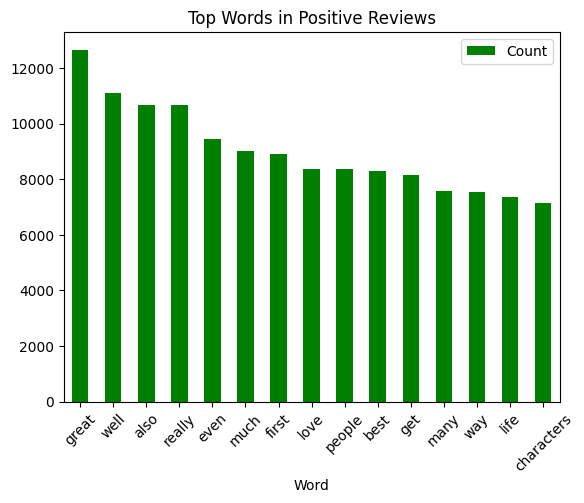

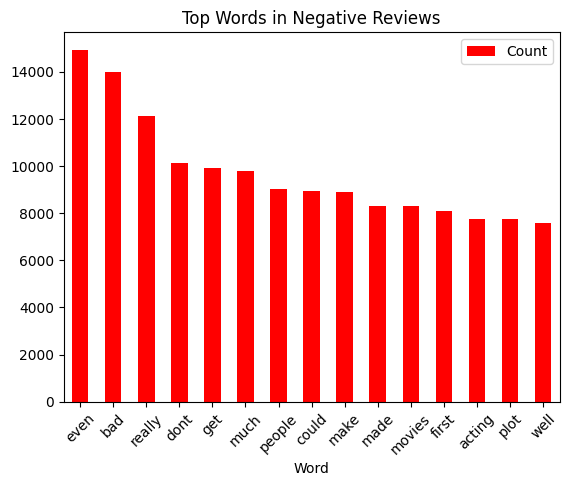

In [11]:
stop_words = set(stopwords.words('english'))
custom_stop_words = {'br', 'like', 'movie', 'film', 'one','story','time','see','would','films','good'}

def tokenize_and_filter(texts):
    tokens = []
    for review in texts:
        words = word_tokenize(review)
        filtered = [w for w in words if w not in stop_words and w not in custom_stop_words and len(w) > 1]
        tokens.extend(filtered)
    return tokens

positive_reviews = df[df['sentiment'] == 1]['clean_review']
negative_reviews = df[df['sentiment'] == 0]['clean_review']

positive_tokens = tokenize_and_filter(positive_reviews)
negative_tokens = tokenize_and_filter(negative_reviews)

# Frequency count
positive_counts = Counter(positive_tokens).most_common(15)
negative_counts = Counter(negative_tokens).most_common(15)

# Plot Positive Words
pd.DataFrame(positive_counts, columns=['Word', 'Count']).plot(
    kind='bar', x='Word', y='Count', color='green', title='Top Words in Positive Reviews'
)
plt.xticks(rotation=45)
plt.show()

# Plot Negative Words
pd.DataFrame(negative_counts, columns=['Word', 'Count']).plot(
    kind='bar', x='Word', y='Count', color='red', title='Top Words in Negative Reviews'
)
plt.xticks(rotation=45)
plt.show()


# N-Gram Analysis

An N-gram is a contiguous sequence of N items from a given sample of text or speech. These "items" are typically words, but they can also be characters, depending on the context and the application. In general, N-grams are a simple yet powerful tool in text analysis and can improve the performance of many NLP tasks.

We analyze unigrams and bigrams to identify important word pairs and phrases. Analyzing n-grams helps us understand important word sequences (e.g., "not good", "highly recommend") that may indicate sentiment. These insights can help us better capture sentiment in the reviews.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_ngram = vectorizer.fit_transform(df['review'])
ngram_freq = np.asarray(X_ngram.sum(axis=0)).flatten()
feature_names = vectorizer.get_feature_names_out()

ngram_df = pd.DataFrame({'ngram': feature_names, 'count': ngram_freq})
top_ngrams = ngram_df.sort_values(by='count', ascending=False).head(10)


# Advanced Text Preprocessing (Lemmatization)

In [13]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered = [t for t in tokens if t not in stop_words]
    lemmatized = [lemmatizer.lemmatize(t) for t in filtered]
    return ' '.join(lemmatized)

df['cleaned_review'] = df['review'].apply(preprocess)

#  Label Encoding

In [14]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0}).fillna(df['sentiment'])  # Handle numeric labels if already 0/1

# Train-Test Split

In [15]:
from sklearn.model_selection import train_test_split

X = df['cleaned_review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("TF-IDF Feature Shape:", X_train_vec.shape)

TF-IDF Feature Shape: (39665, 5000)


# Model Training (Naive Bayes)

In [17]:
# Initial Model Training (Naive Bayes)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

model = MultinomialNB()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

# 4. Evaluate Initial Model
print("Initial Model Evaluation")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Initial Model Evaluation
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4961
         1.0       0.85      0.86      0.85      4956

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917

Confusion Matrix:
 [[4184  777]
 [ 690 4266]]


# Tuning Naive Bayes hyperparameters with GridSearchCV

In [18]:
# Tuning Naive Bayes hyperparameters with GridSearchCV
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.1, 0.5, 1.0, 2.0]}  # Define the hyperparameters to tune
grid_search = GridSearchCV(MultinomialNB(), param_grid=params, cv=5)
grid_search.fit(X_train_vec, y_train)

# Print best hyperparameters from GridSearch
print("Best hyperparameters from GridSearch:", grid_search.best_params_)

Best hyperparameters from GridSearch: {'alpha': 2.0}


Best Model Evaluation
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4961
         1.0       0.85      0.86      0.85      4956

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917

Confusion Matrix:
 [[4185  776]
 [ 694 4262]]


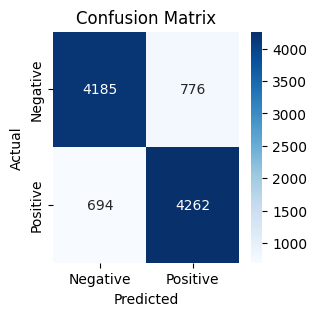

In [19]:
# Retrain the model with the best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_vec)

# Evaluate the model with the best hyperparameters
print("Best Model Evaluation")
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
# Select a random index from the test set (make sure it's within the bounds of X_test)
example_idx_test_set = 555  # Index in the test set (X_test)
example_review = X_test.iloc[example_idx_test_set]  # Review text from test set
actual_sentiment = y_test.iloc[example_idx_test_set]  # Actual sentiment from the test set (1 = Positive, 0 = Negative)

# Preprocess the review (cleaning, tokenizing, lemmatizing)
example_review_cleaned = preprocess(example_review)  # Use your preprocessing function here

# Transform the review using the same TF-IDF vectorizer
example_review_vec = vectorizer.transform([example_review_cleaned])  # Make sure it's a 2D array

# Predict the sentiment using the trained model
predicted_sentiment = best_model.predict(example_review_vec)[0]  # The [0] is to get the scalar result

# Display the review text
print(f"Review: {example_review}")
print(f"Actual Sentiment: {actual_sentiment} (0=Negative, 1=Positive)")
print(f"Predicted Sentiment: {predicted_sentiment} (0=Negative, 1=Positive)")


Review: disregard plot enjoy fred astaire foggy day several dance one duo hapless joan fontaine see astaire essentially stage dance purer form film ginger rogers learned take full advantage potential film best fact see burn allen radiotv husbandwife comedy career kind dancing must done vaudeville chance paramount college film george tap dance instructor two number fred high point film worth waiting first soft shoe trio warmup chin exhilarating carnival number three sing dance ride attraction almost seems spontaneous fan fred astaire burn allen find worth bearing plot ive seen one time find fast forward button helpful
Actual Sentiment: 1.0 (0=Negative, 1=Positive)
Predicted Sentiment: 1.0 (0=Negative, 1=Positive)
